In [86]:
# ===============================================
# Author: HaoYuan Tian
# Date: 2025-03-21
# Email: 2232147@mail.dhu.edu.cn
# Homepage: https://github.com/HaoYuanTian
# Description: Please enter a brief description of the script
# ===============================================

In [1]:
import numpy as np
import time as t
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import FormatStrFormatter 

In [2]:
def set_fig_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """
    Set figure dimensions to avoid scaling issues in LaTeX.

    Parameters
    ----------
    width : float or str
        Document width in points, or a predefined document type.
    fraction : float, optional, default=1
        Fraction of the width that the figure should occupy.
    subplots : tuple, optional, default=(1, 1)
        The number of rows and columns of subplots.

    Returns
    -------
    fig_dim : tuple
        Dimensions of the figure in inches (width, height).
        Note: Tuples are immutable, meaning they cannot be modified once created.
    """

    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # 0.618033988749895

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# print(set_fig_size.__doc__)  # print docstring that is only used to describe the function
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8, 
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)
# plt.rcParams.update()，其中 update 是 rcParams 对象的一个方法，用于更新 Matplotlib 的运行时配置参数。

In [3]:
def coef_closed_loop(rl, eps, lam, tl, nn, al, kl):
    N = len(rl)
    hr = rl[1]-rl[0]
    # 定义常数
    c1 = eps * tl / (2 * hr**2)
    c2 = eps * tl / (4 * hr)
    c3 = tl * lam / 2
    c4 = eps * tl * nn**2 / 2

    # 第一行系数
    a1 = 1 + 2 * c1 - c3[0] + 4 * c4 / (hr**2)
    a2 = -c1 - 2 * c2 / hr
    a3 = 1 - 2 * c1 + c3[0] - 4 * c4 / (hr**2)
    a4 = c1 + 2 * c2 / hr

    # 计算控制系数
    Atc_n = -1/2 * al *kl
    Atc_n[0][-1] = -Atc_n[0][-1]/2 +1
    Ac_n = 1/2 * al *kl

    # 初始化系数矩阵的稀疏结构
    data_at = [a1,a2]
    column_at = [0,1]
    offset_at = [0] # 存储的每一个数字表示对应行的第一个非零元素在data中的索引，第一个数字表示第一行，第二个数字表示第二行数据从date中的第几个元素索引。
    data_a = [a3,a4]
    column_a = [0,1]
    offset_a = [0]

    rrl = rl[1:-1]
    #构建At矩阵系数
    At_1 = -(c1 * np.ones(N-2)) + c2 / rrl   # for i-1
    At_2 = (1 + 2 * c1) * np.ones(N-2) - c3[1:-1] + c4 / (rrl**2)  # for i
    At_3 = -c1 * np.ones(N-2) - c2 / rrl 

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置 即这一行第一个数据在data中的索引号
        offset_at.append(len(data_at))
        # 第一部分下对角线
        data_at.append(At_1[i-1]) # 在data中添加数据 取数组中第i-1个元素是因为循环是从1开始的（因为第一行是手动设置），而数组中的索引是从0开始的（只包含可以循环添加的部分）。
        column_at.append(i-1) # 记录列向量位置 i-1是因为是下对角线，i为行数，i-1为列数

        # 第二部分对角线
        data_at.append(At_2[i-1])
        column_at.append(i)

        # 第三部分上对角线
        data_at.append(At_3[i-1])
        column_at.append(i+1)
    
    # 定义边界条件控制律
    # 在python中索引是从0开始，则对于即将被添加的数据索引为“添加前数组的长度”，长度为n，索引为n，但实际为第n+1个元素（刚好为新增）。
    offset_at.append(len(data_at)) 
    
    for i in range(0,N):
        data_at.append(Atc_n[0][i])
        column_at.append(i)
    
    offset_at.append(len(data_at)) # 行偏移向量中的最后一个元素是非零元素的个数

    # 构建At矩阵
    At = csr_matrix((data_at, column_at, offset_at), shape=(N, N))

    # 构建A矩阵系数
    A_1 = c1 * np.ones(N-2) - c2 / rrl
    A_2 = (1 - 2 * c1) * np.ones(N-2) + c3[1:-1] - c4 / (rrl**2)
    A_3 = c1 * np.ones(N-2) + c2 / rrl

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_a.append(len(data_a))
        # 第一部分下对角线
        data_a.append(A_1[i-1])
        column_a.append(i-1)

        # 第二部分对角线
        data_a.append(A_2[i-1])
        column_a.append(i)

        # 第三部分上对角线
        data_a.append(A_3[i-1])
        column_a.append(i+1)
    
    # 定义边界条件
    offset_a.append(len(data_a)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    
    for i in range(0,N):
        data_a.append(Ac_n[0][i])
        column_a.append(i)

    offset_a.append(len(data_a)) # 行偏移向量中的最后一个元素是非零元素的个数

    A = csr_matrix((data_a, column_a, offset_a), shape=(N, N))

    return(At, A)

# 生成用于求解复合辛普森积分的系数序列
def ComSimpson(N, hr):
    # hr = delta_r
    c = np.ones((1,N))*2
    c[0,1:N-1:2] = 4
    c[0,0] = 1
    c[0,N-1] = 1
    c = hr/3*c
    return c
# with open("solve_kernel.py", "w", encoding="utf-8") as f:
#     f.write(code)

In [96]:
import solve_kernel as sk
# # 修改了solve_kernel.py文件后，需要重新导入
# import importlib
# importlib.reload(sk)

# initial
R_max = 1
eps = 1 # diffusion coefficient

# for time
final_time = 1
t_step = 0.0001
Max_step = int(final_time/t_step) # calculate the number of time steps
time = np.arange(0,final_time+t_step,t_step) 
time = time[1:]
ratio = 1
# time for draw
time1 = time[::ratio] # 切片（slicing）语法，提取time数组中的元素，提出每隔ratio个元素的子集
Rstep1 = time[1] - time[0]
Max_step1 = len(time1)
# for sptial
N = 91
delta_r = (2*R_max)/(2*(N-1)+1)
r = np.arange(1, N+1, dtype=np.float64) # 生成左闭右开的范围，步长默认为1
r = (r- 1/2)*delta_r

# random condition (can be changed)
n = 0 # power of fourier series
lamda = 50*r**2
# 需要修改一下下面的定义
# a_con = 40
# b_cos = 20
# lamda = a_con - b_cos*np.cos(np.pi*r)
# thy = [-b_cos, b_cos, -b_cos, b_cos, -b_cos, b_cos]
# a0z = a_con
# lamda = 40*r**4+30*1j*r**2

# uu = np.zeros((N,Max_step1))

In [97]:
def Fdm(lam, delta_r, c, eps, n):
    k = np.zeros((len(lam), len(lam)), dtype=np.float64)
    a = lam

    # FD loop
    k[1][1] = -((((a[1] + a[0])/2) +c)/(2 * eps)) * delta_r
    for i in range(1, len(lam)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i] -(((((a[i+1] + a[i])/2) +c)/(2 * eps)) * delta_r)
        # k[i+1][i] 在此处启用时，在j循环中应该删除
        k[i+1][i] = k[i][i] -(((((a[i])/2) +c) / (2 * eps)) * delta_r) 
        F = (delta_r ** 2 * (r[i+1] + r[i-1]))/(delta_r + r[i+1] + r[i-1]) 
        for j in range(1, i):
            k[i+1][j] = (
                        (k[i-1][j] / (delta_r * (r[i+1] + r[i-1]))) + (((2 * k[i][j]) - k[i-1][j]) / delta_r**2) + ((k[i][j+1] -2 * k[i][j] + k[i][j-1]) / delta_r**2) - 
                        ((k[i][j+1] - k[i][j-1]) / delta_r * (r[j+1] + r[j-1])) + ((k[i][j+1] + k[i][j-1]) / 2) * ((n**2) / (r[i]**2) - ((n**2 - 1) / ((r[j+1] + r[j-1]) / 2) ** 2) +
                        (0.5*(a[j+1] + a[j-1]) + c) / eps) 
                        ) * F

    k_bud = k[-1,:]

    return k_bud, k

In [98]:
# 计算控制增益
c = 1
a = ComSimpson(N, delta_r)
# [K, kernel] = sk.getK_cos(r, n, thy, a0z, c)
# [K, kernel] = sk.getK(r, n)
[K, kernel] = Fdm(lamda, delta_r, c, eps, n)
# 计算At和A矩阵
[At, A] = coef_closed_loop(r, eps, lamda, t_step, n, a, K)

In [99]:
# initial
u = np.zeros((N, Max_step1)) 
u_inital = 5 * np.ones(N)
u_inital[-1] = 0
u[:,0] = u_inital

In [100]:
# 计算u_open
R = A @ u_inital
ratio = 1
# 定义时间步循环
sn = 1
for i in range(1, Max_step1):
    u2 = spsolve(At, R)
    R = A @ u2 # 更新等式右边 R
    if i % ratio == 0:
        u[:,sn] = u2
        sn +=1

u_squared = u**2
error = (np.sum(u_squared, axis=0))**0.5

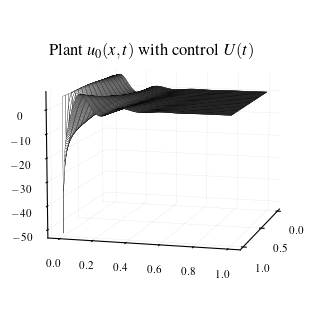

In [103]:
# 初始设置与图形创建
# fig = plt.figure(figsize=set_size(1024, 0.49, (1,2), height_add=0.5))
# subfigs = fig.subfigures(nrows=1, ncols=2, width_ratios=[1, 1], height_ratios=[1])
# subfig0 = subfigs[0]
# subfig1 = subfigs[1]
fig = plt.figure(figsize=set_fig_size(522, 0.49, (1,1), height_add=0.5))
subfigs = fig.subfigures(nrows=1, ncols=1)
subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(fr"Plant $u_{n}(x, t)$ with control $U(t)$")
# subfig0.subplots_adjust(left=0.07, bottom=0, right=1, top=0.9)
# subfig1.subplots_adjust(left=0.15, bottom=0, right=1, top=0.9)
# subfig0.suptitle(r"Plant $u(x, t)$ with openloop $U(t)=0$")
# subfig0.suptitle(r"$\|\mathbf{u}(t,r)\|_{L^2}$")

axes0 = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
# axes0.set_title(r"Plant $u(x, t)$ with openloop $U(t)=0$")

for axis in [axes0.xaxis, axes0.yaxis, axes0.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(r, time1)
uopen = u.transpose()

                     
axes0.plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=20, cstride=5, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes0.view_init(10, 15)
axes0.zaxis.set_rotate_label(False)
axes0.set_xticks([0, 0.5, 1])
axes0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# axes1 = subfig1.subplots(nrows=1, ncols=1)
# # axes1.set_title(r"$\|\mathbf{u}(t,r)\|_{L^2}$")
# axes1.plot(time1, error, 'm.-', label='Error')
# axes1.set_xlabel('Time (sec)')
# axes1.set_ylabel(r'$|| \mathbf{u}(t,r) ||_{L^2}$')


# folder_path = r"/Users/thy/Documents/MATLAB/MASs/Py/code_radially_varying/un/result/cos"
folder_path = r"/Users/thy/Documents/MATLAB/MASs/Py/code_radially_varying/un/result/fdm/normal"
os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, f"control_loop{n}.pdf")
plt.savefig(save_path, dpi=300)


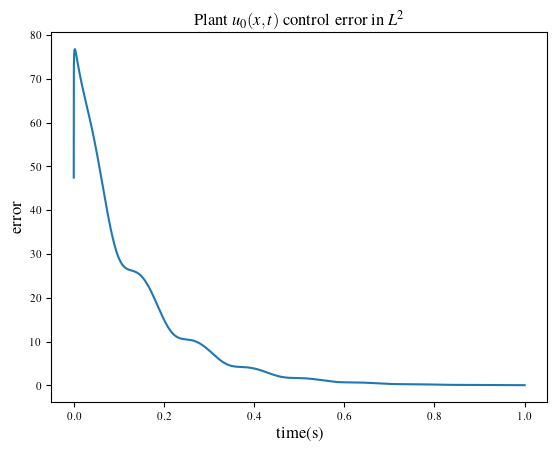

In [102]:
fig = plt.figure()
plt.plot(time1, error)
plt.title(fr"Plant $u_{n}(x, t)$ control error in $L^2$")
plt.xlabel('time(s)', fontsize=12)
plt.ylabel('error', fontsize=12)

save_path = os.path.join(folder_path, f"error_L^2_control{n}.pdf")
plt.savefig(save_path, dpi=300)